In [1]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from data_handler import merger, PhilDataGetter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Grab Data

In [14]:
fpi_path = "./Data/PHL_food_price_indices.csv"
cpi_path = "./Data/PHL_consumer_price_indices.csv"
ppi_path = "./Data/PHL_producer_price_indices.csv"
er_path = "./Data/PHL_exchange_rates.csv"
gov_path = "./Data/PHL_gov_indicators_yearly.csv"
dataGetter = PhilDataGetter(fpi_path, er_path)

In [5]:
fpi = dataGetter.get_market_data(target_markets='Market Average', target_products='food_price_index', data_type='fpi')
er = dataGetter.get_market_data(target_markets="Metro Manila", data_type='er')
fpi = pd.DataFrame({"FPI(Mean)":fpi.mean(axis=1) * 100})  # Take means of Open, Close, High, Low
er = pd.DataFrame({"ExRate(Mean)":er.mean(axis=1)})

ppi = pd.read_csv(ppi_path, index_col=0)
ppi.index = pd.to_datetime(ppi.index)
ppi = ppi.asfreq("MS") 


cpi = pd.read_csv(cpi_path, index_col=0)
cpi = cpi.drop(labels=['CPI_Change_Prev_Yr','CPI_Change_Prev_Mon'], axis=1)
cpi.index = pd.to_datetime(cpi.index)
cpi = cpi.asfreq('MS')
cpi_dates = ('2011-01-01', '2023-06-01')
cpi_date_range = pd.date_range(*cpi_dates, freq='MS')

gov = pd.read_csv(gov_path, index_col=0)
gov.index = pd.to_datetime(gov.index)
gov = gov.asfreq('YS')

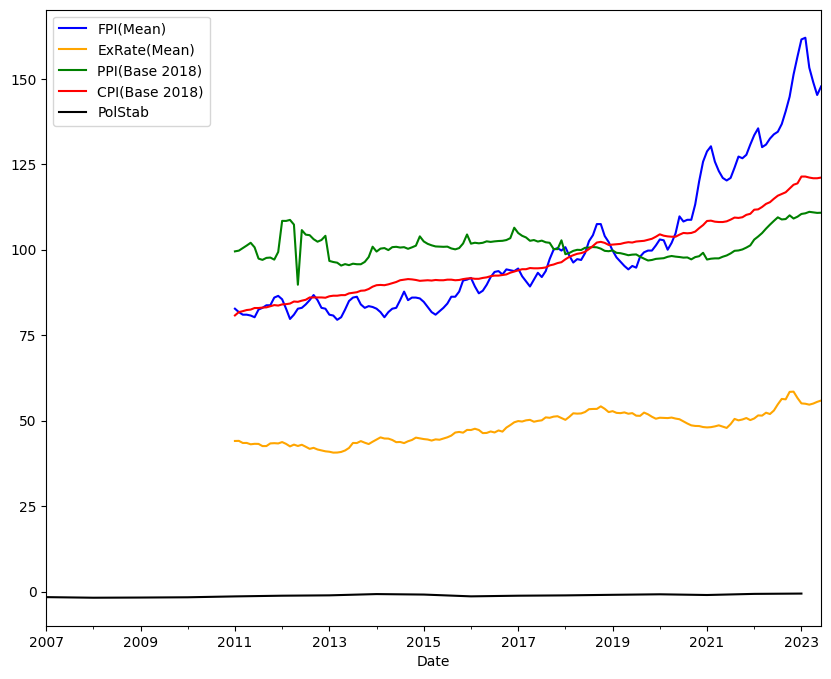

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
fpi.loc[cpi_date_range.to_series()].plot(legend=True, label='FPI', color='blue', ax=ax)
er.loc[cpi_date_range.to_series()].plot(legend=True, label='ExRate', color='orange', ax=ax)
ppi.loc[cpi_date_range.to_series()].plot(legend=True, ax=ax, color='green')
cpi['CPI(Base 2018)'].plot(ax=ax, color='red', label='CPI(Base 2018)', legend=True)
gov["PSAVT"].plot(ax=ax, color='black', label='PolStab', legend=True)
plt.show()

# Make One Giant ```DataFrame```
CPI and Government indicators are the limiting value, so use the start of CPI and end of indicators

In [15]:
training_dates = ('2011-01-01', '2022-12-01')
df = merger(dfs=[fpi, er, ppi, cpi, gov], date_range=training_dates)
df = df.drop(labels=['RegQual', 'RuleOfLaw', 'VoiceAcct', 'GovEff', 'ContCorr'], axis=1)
pred_dates = pd.date_range('2023-01-01', end='2024-01-01', freq='MS') # Predict all 2023 up to start of 2024 (13 Obs)

# Modeling: Exponential Smoothing

## Simple Exponential Smoothing

In [17]:
simpExp = SimpleExpSmoothing(df['FPI(Mean)'], initialization_method='estimated')
simpExp_fit = simpExp.fit()

In [18]:
in_sample_preds = pd.DataFrame({"Model Fit":simpExp_fit.predict(*training_dates)})
out_sample_preds = pd.DataFrame({"Model Pred":simpExp_fit.forecast(13)})

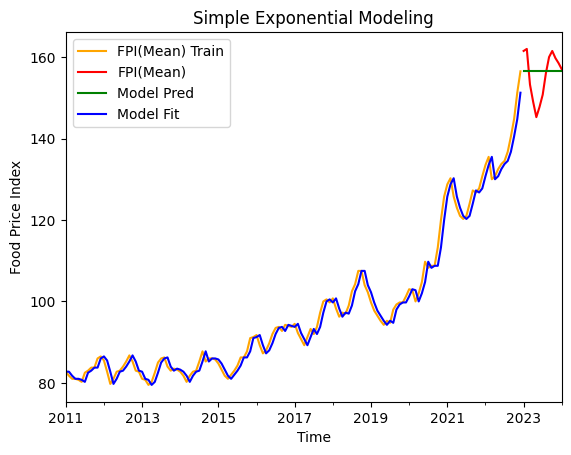

In [22]:
ax = plt.subplot(111)
df['FPI(Mean)'].plot(ax=ax, color='orange', legend=True, label='FPI(Mean) Train')
(fpi.loc[pred_dates.to_series()]).plot(ax=ax, color='red')
out_sample_preds.plot(ax=ax, color='green', legend=True)
in_sample_preds.plot(ax=ax, color='blue', legend=True)
ax.set_ylabel('Food Price Index')
ax.set_xlabel('Time')
ax.set_title("Simple Exponential Modeling")
ax.legend()
plt.show()

## Holt Smoothing (Double Smoothing)

In [23]:
holtExp = Holt(df['FPI(Mean)'], exponential=True, damped_trend=True)
holtExp_fit = holtExp.fit()

In [24]:
in_sample_preds = pd.DataFrame({"Model Fit":holtExp_fit.predict(*training_dates)})
out_sample_preds = pd.DataFrame({"Model Pred":holtExp_fit.forecast(13)})

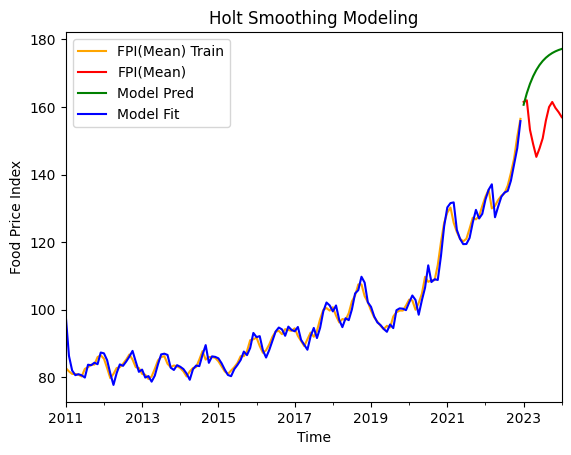

In [25]:
ax = plt.subplot(111)
df['FPI(Mean)'].plot(ax=ax, color='orange', legend=True, label='FPI(Mean) Train')
(fpi.loc[pred_dates.to_series()]).plot(ax=ax, color='red')
out_sample_preds.plot(ax=ax, color='green', legend=True)
in_sample_preds.plot(ax=ax, color='blue', legend=True)
ax.set_ylabel('Food Price Index')
ax.set_xlabel('Time')
ax.set_title("Holt Smoothing Modeling")
ax.legend()
plt.show()

## Holt-Winters Smoothing (Triple Smoothing)

In [26]:
holtWint = ExponentialSmoothing(df['FPI(Mean)'], trend='add', damped_trend=True, seasonal='mul')
holtWint_fit = holtWint.fit()

In [29]:
in_sample_preds = pd.DataFrame({'Model Fit':holtWint_fit.predict('2011-01-01', '2022-12-01')})
out_sample_preds = pd.DataFrame({'Model Pred':holtWint_fit.forecast(13)})

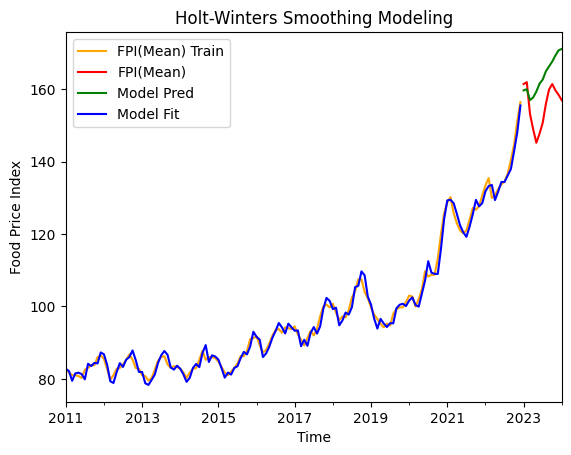

In [30]:
ax = plt.subplot(111)
df['FPI(Mean)'].plot(ax=ax, color='orange', legend=True, label='FPI(Mean) Train')
(fpi.loc[pred_dates.to_series()]).plot(ax=ax, color='red')
out_sample_preds.plot(ax=ax, color='green', legend=True)
in_sample_preds.plot(ax=ax, color='blue', legend=True)
ax.set_ylabel('Food Price Index')
ax.set_xlabel('Time')
ax.set_title("Holt-Winters Smoothing Modeling")
ax.legend()
plt.show()